In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import io
import os

In [2]:
def getStockMarketData(ticker):
    '''
    timestamp,open,high,low,close,volume
    '''
    # If you have already saved data, just load it from the file
    df = pd.read_csv(f'./data/stock_market_data-{ticker}.csv', parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Clean the data - remove rows where OHLC values are missing
    # Keep only rows where open, high, low, close are not null and not empty strings
    df = df.replace('', np.nan)  # Replace empty strings with NaN
    df = df.dropna(subset=['open', 'high', 'low', 'close'])  # Drop rows with missing OHLC data
    
    # Optionally, you can also filter out rows where volume is 0 if that indicates invalid data
    # df = df[df['volume'] > 0]
    
    return df

def getOperation(file_path):
    '''
    timestamp,Decision,Hands
    '''
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Operation file {file_path} does not exist.")
    
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Clean operation data if needed
    df = df.replace('', np.nan)
    df = df.dropna()  # Remove rows with any missing values
    
    return df

In [3]:
def sync_data_by_date_range(df_market, df_operation):
    """
    Get date range from df_operation and sync with df_market data
    If date exists in df_market but not in df_operation, add it to df_operation with 0 values
    Returns filtered dataframes with common date range
    """
    # Get the date range from df_operation (start and end dates)
    df_market = df_market.sort_index()
    operation_start_date = df_operation.index.min()
    operation_end_date = df_operation.index.max()
    
    print(f"Operation date range: {operation_start_date} to {operation_end_date}")
    
    # Filter df_market to the same date range
    df_market_filtered = df_market.loc[operation_start_date:operation_end_date]
    
    print(f"Market data entries in date range: {len(df_market_filtered)}")
    print(f"Operation data entries: {len(df_operation)}")
    
    # Reindex df_operation to match df_market_filtered dates, filling missing dates with 0
    df_operation_synced = df_operation.reindex(df_market_filtered.index, fill_value=0)
    
    # Keep the market data as is (already filtered to the date range)
    df_market_synced = df_market_filtered
    
    print(f"After synchronization:")
    print(f"Number of dates: {len(df_market_synced)}")
    print(f"Date range: {df_market_synced.index.min()} to {df_market_synced.index.max()}")
    
    return df_market_synced, df_operation_synced

In [4]:
def calculate_returns(df_market_synced, df_operation_synced, initial_capital=1000):
    """
    Calculate returns based on trading operations with high initial capital
    Decision: 1 = buy, -1 = sell, 0 = hold
    Hands: number of shares to trade
    """
    # Create a copy and ensure proper data types
    df_combined = df_market_synced.copy()
    df_combined['Decision'] = pd.to_numeric(df_operation_synced['Decision'], errors='coerce').fillna(0).astype(int)
    df_combined['Hands'] = pd.to_numeric(df_operation_synced['Hands'], errors='coerce').fillna(0).astype(int)

    initial_capital = initial_capital * df_combined['close'][0]
    
    # Initialize tracking variables
    portfolio_values = []
    cash = float(initial_capital)
    shares_held = int(0)
    trade_log = []
    
    for i, (date, row) in enumerate(df_combined.iterrows()):
        price = float(row['close'])
        decision = int(row['Decision'])
        hands = int(row['Hands'])
        
        # BUY LOGIC
        if decision == 1 and hands > 0:
            trade_cost = float(hands) * price
            if cash >= trade_cost:
                cash = cash - trade_cost
                shares_held = shares_held + hands
                trade_log.append({
                    'date': date,
                    'action': 'BUY',
                    'shares': hands,
                    'price': price,
                    'value': trade_cost,
                    'cash_after': cash,
                    'shares_after': shares_held
                })
            else:
                # Partial buy with available cash
                affordable_shares = int(cash / price)
                if affordable_shares > 0:
                    actual_cost = float(affordable_shares) * price
                    cash = cash - actual_cost
                    shares_held = shares_held + affordable_shares
                    trade_log.append({
                        'date': date,
                        'action': 'PARTIAL_BUY',
                        'shares': affordable_shares,
                        'price': price,
                        'value': actual_cost,
                        'cash_after': cash,
                        'shares_after': shares_held
                    })
        
        # SELL LOGIC
        elif decision == -1 and hands > 0:
            shares_to_sell = min(hands, shares_held)
            if shares_to_sell > 0:
                trade_value = float(shares_to_sell) * price
                cash = cash + trade_value
                shares_held = shares_held - shares_to_sell
                trade_log.append({
                    'date': date,
                    'action': 'SELL',
                    'shares': shares_to_sell,
                    'price': price,
                    'value': trade_value,
                    'cash_after': cash,
                    'shares_after': shares_held
                })
        
        # Calculate current portfolio value
        current_portfolio_value = cash + (float(shares_held) * price)
        portfolio_values.append(current_portfolio_value)
    
    # Add calculated columns to dataframe
    df_combined['Portfolio_Value'] = portfolio_values
    df_combined['Cash'] = cash
    df_combined['Shares_Held'] = shares_held
    
    # Calculate returns
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital
    
    # Calculate daily returns
    df_combined['Daily_Return'] = df_combined['Portfolio_Value'].pct_change()
    
    # Calculate cumulative returns
    df_combined['Cumulative_Return'] = (df_combined['Portfolio_Value'] / initial_capital) - 1
    
    # Calculate buy and hold return for comparison
    initial_price = float(df_combined['close'].iloc[0])
    final_price = float(df_combined['close'].iloc[-1])
    buy_hold_return = (final_price - initial_price) / initial_price
    
    # Performance metrics
    performance_metrics = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_value,
        'Total Return': total_return,
        'Total Return (%)': total_return * 100,
        'Buy & Hold Return (%)': buy_hold_return * 100,
        'Excess Return (%)': (total_return - buy_hold_return) * 100,
        'Number of Trades': len(trade_log),
        'Final Cash': cash,
        'Final Shares': shares_held,
        'Final Stock Price': final_price,
        'Annualized Return (%)': (((final_value / initial_capital) ** (252 / len(df_combined))) - 1) * 100,
    }
    
    # Calculate additional risk metrics
    if len(df_combined['Daily_Return'].dropna()) > 1:
        daily_returns = df_combined['Daily_Return'].dropna()
        performance_metrics.update({
            'Volatility (%)': daily_returns.std() * np.sqrt(252) * 100,
            'Sharpe Ratio': (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252)) if daily_returns.std() > 0 else 0,
            'Max Drawdown (%)': ((df_combined['Portfolio_Value'] / df_combined['Portfolio_Value'].cummax()) - 1).min() * 100
        })
    
    return df_combined, pd.DataFrame(trade_log), performance_metrics

In [5]:
def plot_performance_analysis(df_results, metrics):
    """
    Create comprehensive performance visualization
    """
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle('Trading Strategy Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Portfolio Value vs Stock Price
    ax1_twin = ax1.twinx()
    
    # Portfolio value (left axis)
    line1 = ax1.plot(df_results.index, df_results['Portfolio_Value'], 
                     'b-', label='Portfolio Value', linewidth=2.5, alpha=0.8)
    ax1.set_ylabel('Portfolio Value ($)', color='b', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B' if x >= 1e9 else f'${x/1e6:.1f}M'))
    
    # Stock price (right axis)
    line2 = ax1_twin.plot(df_results.index, df_results['close'], 
                          'r--', label='Stock Price', linewidth=2, alpha=0.7)
    ax1_twin.set_ylabel('Stock Price ($)', color='r', fontweight='bold')
    ax1_twin.tick_params(axis='y', labelcolor='r')
    
    ax1.set_title('Portfolio Value vs Stock Price', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    
    # 2. Cumulative Returns Comparison
    strategy_returns = df_results['Cumulative_Return'] * 100
    buy_hold_returns = (df_results['close'] / df_results['close'].iloc[0] - 1) * 100
    
    ax2.plot(df_results.index, strategy_returns, 
             'g-', label='Strategy Return', linewidth=2.5, alpha=0.8)
    ax2.plot(df_results.index, buy_hold_returns, 
             'orange', label='Buy & Hold Return', linestyle='--', linewidth=2, alpha=0.8)
    
    ax2.set_ylabel('Cumulative Return (%)', fontweight='bold')
    ax2.set_title('Cumulative Returns Comparison', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add performance text box
    textstr = f'Strategy: {metrics["Total Return (%)"]:.2f}%\nBuy&Hold: {metrics["Buy & Hold Return (%)"]:.2f}%\nExcess: {metrics["Excess Return (%)"]:.2f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax2.text(0.62, 0.98, textstr, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # 3. Trading Activity
    ax3.plot(df_results.index, df_results['close'], 
             'k-', alpha=0.6, label='Stock Price', linewidth=1.5)
    
    # Mark buy and sell points
    buy_dates = df_results[df_results['Decision'] == 1].index
    sell_dates = df_results[df_results['Decision'] == -1].index
    
    if len(buy_dates) > 0:
        ax3.scatter(buy_dates, df_results.loc[buy_dates, 'close'], 
                   color='green', marker='^', s=100, label='Buy', alpha=0.8, edgecolors='darkgreen')
    
    if len(sell_dates) > 0:
        ax3.scatter(sell_dates, df_results.loc[sell_dates, 'close'], 
                   color='red', marker='v', s=100, label='Sell', alpha=0.8, edgecolors='darkred')
    
    ax3.set_ylabel('Stock Price ($)', fontweight='bold')
    ax3.set_title('Trading Activity', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Portfolio Composition Over Time
    # Calculate cash and stock value over time
    stock_values = df_results['Shares_Held'] * df_results['close']
    cash_values = df_results['Portfolio_Value'] - stock_values
    
    ax4.fill_between(df_results.index, 0, cash_values, 
                     label='Cash', alpha=0.6, color='lightblue')
    ax4.fill_between(df_results.index, cash_values, df_results['Portfolio_Value'], 
                     label='Stock Holdings', alpha=0.6, color='lightcoral')
    
    ax4.set_ylabel('Value ($)', fontweight='bold')
    ax4.set_title('Portfolio Composition', fontweight='bold')
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B' if x >= 1e9 else f'${x/1e6:.1f}M'))
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # Format x-axis for all subplots
    for ax in [ax1, ax2, ax3, ax4]:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics table
    print("\n" + "="*60)
    print("DETAILED PERFORMANCE METRICS")
    print("="*60)
    
    # Format metrics for display
    formatted_metrics = {}
    for key, value in metrics.items():
        if isinstance(value, float):
            if 'Capital' in key or 'Value' in key or 'Cash' in key or 'Price' in key:
                if value >= 1e9:
                    formatted_metrics[key] = f"${value/1e9:.2f}B"
                elif value >= 1e6:
                    formatted_metrics[key] = f"${value/1e6:.2f}M"
                else:
                    formatted_metrics[key] = f"${value:,.2f}"
            elif '%' in key or 'Return' in key or 'Ratio' in key:
                formatted_metrics[key] = f"{value:.4f}" if 'Ratio' in key else f"{value:.2f}%"
            else:
                formatted_metrics[key] = f"{value:.2f}"
        else:
            formatted_metrics[key] = str(value)
    
    # Create and display metrics table
    metrics_df = pd.DataFrame(list(formatted_metrics.items()), columns=['Metric', 'Value'])
    print(metrics_df.to_string(index=False))
    
    return fig

def calculate_returns_for_all_methods(df_market, df_operations, methods, initial_capital=1000):
    """
    Calculate returns for all trading methods
    """
    all_results = {}
    all_trade_logs = {}
    all_metrics = {}
    
    print("Processing all methods...")
    
    for i, (method, df_operation) in enumerate(zip(methods, df_operations)):
        print(f"\nProcessing {method}...")
        
        # Sync data for this method
        df_market_synced, df_operation_synced = sync_data_by_date_range(df_market, df_operation)
        
        # Calculate returns
        df_results, trade_log, metrics = calculate_returns(df_market_synced, df_operation_synced, initial_capital)
        
        # Store results
        all_results[method] = df_results
        all_trade_logs[method] = trade_log
        all_metrics[method] = metrics
        
        # Print summary
        print(f"  Total Return: {metrics['Total Return (%)']:.2f}%")
        print(f"  Number of Trades: {metrics['Number of Trades']}")
        print(f"  Final Value: ${metrics['Final Portfolio Value']/1e9:.2f}B")
    
    return all_results, all_trade_logs, all_metrics

def plot_methods_comparison(all_results, all_metrics, methods):
    """
    Create comprehensive comparison plots for all trading methods
    Fixed version with correct gridspec
    """
    # Filter to only methods that have results
    available_methods = [method for method in methods if method in all_results and method in all_metrics]
    
    if not available_methods:
        print("No methods with results available for plotting!")
        return None
    
    print(f"Plotting {len(available_methods)} methods: {available_methods}")
    
    # Set up the plotting style
    plt.style.use('default')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Create figure with subplots - FIXED: add_gridspec instead of add_gridset
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 3, hspace=0.2, wspace=0.2)
    
    # Main title
    # fig.suptitle('Trading Methods Performance Comparison', fontsize=20, fontweight='bold', y=0.95)
    
    # 1. Portfolio Values Comparison (Large plot)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Get common date range
    common_dates = None
    for method in available_methods:
        df_results = all_results[method]
        if common_dates is None:
            common_dates = df_results.index
        else:
            common_dates = common_dates.intersection(df_results.index)
    
    for i, method in enumerate(available_methods):
        df_results = all_results[method]
        # Filter to common dates
        df_filtered = df_results.loc[common_dates] if common_dates is not None else df_results
        # df_filtered['Portfolio_Value'] = df_filtered['Portfolio_Value'] - df_filtered['Portfolio_Value'][0]
        ax1.plot(df_filtered.index, df_filtered['Portfolio_Value'], 
                label=method, linewidth=2.5, alpha=0.8, color=colors[i % len(colors)])
    
    # Add Buy & Hold for comparison
    if available_methods:
        sample_df = all_results[available_methods[0]]
        if common_dates is not None:
            sample_df = sample_df.loc[common_dates]
        initial_price = sample_df['close'].iloc[0]
        buy_hold_value = 1000 * initial_price * (sample_df['close'] / initial_price)
        ax1.plot(sample_df.index, buy_hold_value, 
                '--', label='Buy & Hold', linewidth=2, alpha=0.7, color='black')
    
    ax1.set_ylabel('Portfolio Value ($)', fontweight='bold', fontsize=12)
    ax1.set_title('Portfolio Value Evolution', fontweight='bold', fontsize=14)
    ax1.yaxis.set_major_formatter(
        plt.FuncFormatter(
            lambda x, p: (
                f'${x/1e9:.1f}B' if abs(x) >= 1e9 else
                f'${x/1e6:.1f}M' if abs(x) >= 1e6 else
                f'${x/1e3:.1f}K' if abs(x) >= 1e3 else
                f'${x:,.0f}'
            )
        )
    )
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add right y-axis for % return
    ax1_right = ax1.twinx()
    # Use the first available method as reference for initial value
    if available_methods:
        ref_method = available_methods[0]
        ref_df = all_results[ref_method]
        if common_dates is not None:
            ref_df = ref_df.loc[common_dates]
        initial_val = ref_df['Portfolio_Value'].iloc[0]
        pct_return = (ref_df['Portfolio_Value'] / initial_val - 1) * 100
        ax1_right.plot(ref_df.index, pct_return, color='none')  # invisible, just to set scale
        ax1_right.set_ylabel('Return (%)', fontweight='bold', fontsize=12)
        ax1_right.tick_params(axis='y')
        ax1_right.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    
    # # 2. Cumulative Returns Comparison
    # ax2 = fig.add_subplot(gs[1, 0])
    
    # for i, method in enumerate(available_methods):
    #     df_results = all_results[method]
    #     df_filtered = df_results.loc[common_dates] if common_dates is not None else df_results
    #     cumulative_returns = df_filtered['Cumulative_Return'] * 100
    #     ax2.plot(df_filtered.index, cumulative_returns, 
    #             label=method, linewidth=2, alpha=0.8, color=colors[i % len(colors)])
    
    # # Add Buy & Hold
    # if available_methods:
    #     sample_df = all_results[available_methods[0]]
    #     if common_dates is not None:
    #         sample_df = sample_df.loc[common_dates]
    #     buy_hold_returns = (sample_df['close'] / sample_df['close'].iloc[0] - 1) * 100
    #     ax2.plot(sample_df.index, buy_hold_returns, 
    #             '--', label='Buy & Hold', linewidth=2, alpha=0.7, color='black')
    
    # ax2.set_ylabel('Cumulative Return (%)', fontweight='bold')
    # ax2.set_title('Cumulative Returns', fontweight='bold')
    # ax2.grid(True, alpha=0.3)
    # ax2.legend()
    # ax2.tick_params(axis='x', rotation=45)
    
    # 3. Performance Metrics Bar Chart
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Only use available methods
    returns = [all_metrics[method]['Total Return (%)'] for method in available_methods]
    buy_hold_return = all_metrics[available_methods[0]]['Buy & Hold Return (%)'] if available_methods else 0
    
    bars = ax3.bar(range(len(available_methods)), returns, 
                   color=colors[:len(available_methods)], alpha=0.7)
    ax3.axhline(y=buy_hold_return, color='black', linestyle='--', alpha=0.7, label='Buy & Hold')
    
    ax3.set_ylabel('Total Return (%)', fontweight='bold')
    ax3.set_title('Total Returns Comparison', fontweight='bold')
    ax3.set_xticks(range(len(available_methods)))
    ax3.set_xticklabels(available_methods, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.legend()
    
    # Add value labels on bars
    for bar, return_val in zip(bars, returns):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{return_val:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # # 4. Number of Trades Comparison
    # ax4 = fig.add_subplot(gs[1, 2])
    
    # trade_counts = [all_metrics[method]['Number of Trades'] for method in available_methods]
    # bars2 = ax4.bar(range(len(available_methods)), trade_counts, 
    #                 color=colors[:len(available_methods)], alpha=0.7)
    
    # ax4.set_ylabel('Number of Trades', fontweight='bold')
    # ax4.set_title('Trading Activity', fontweight='bold')
    # ax4.set_xticks(range(len(available_methods)))
    # ax4.set_xticklabels(available_methods, rotation=45, ha='right')
    # ax4.grid(True, alpha=0.3, axis='y')
    
    # # Add value labels on bars
    # for bar, count in zip(bars2, trade_counts):
    #     height = bar.get_height()
    #     ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
    #             f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Risk-Return Scatter Plot
    ax5 = fig.add_subplot(gs[1, 0])
    
    for i, method in enumerate(available_methods):
        metrics = all_metrics[method]
        x = metrics.get('Volatility (%)', 0)
        y = metrics['Total Return (%)']
        ax5.scatter(x, y, s=150, alpha=0.7, color=colors[i % len(colors)], 
                   label=method, edgecolors='black', linewidth=1)
    
    # Add Buy & Hold point
    if available_methods:
        # Calculate buy & hold volatility from price data
        sample_df = all_results[available_methods[0]]
        price_returns = sample_df['close'].pct_change().dropna()
        buy_hold_vol = price_returns.std() * np.sqrt(252) * 100
        ax5.scatter(buy_hold_vol, buy_hold_return, s=150, alpha=0.7, color='black', 
                   marker='s', label='Buy & Hold', edgecolors='white', linewidth=1)
    
    ax5.set_xlabel('Volatility (%)', fontweight='bold')
    ax5.set_ylabel('Total Return (%)', fontweight='bold')
    ax5.set_title('Risk vs Return', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    # # 6. Sharpe Ratio Comparison
    # ax6 = fig.add_subplot(gs[2, 1])
    
    # sharpe_ratios = []
    # sharpe_methods = []
    # for method in available_methods:
    #     if 'Sharpe Ratio' in all_metrics[method]:
    #         sharpe_ratios.append(all_metrics[method]['Sharpe Ratio'])
    #         sharpe_methods.append(method)
    
    # if sharpe_ratios:
    #     bars3 = ax6.bar(range(len(sharpe_methods)), sharpe_ratios, 
    #                    color=colors[:len(sharpe_methods)], alpha=0.7)
    #     ax6.set_ylabel('Sharpe Ratio', fontweight='bold')
    #     ax6.set_title('Risk-Adjusted Returns', fontweight='bold')
    #     ax6.set_xticks(range(len(sharpe_methods)))
    #     ax6.set_xticklabels(sharpe_methods, rotation=45, ha='right')
    #     ax6.grid(True, alpha=0.3, axis='y')
    #     ax6.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
    #     # Add value labels
    #     for bar, ratio in zip(bars3, sharpe_ratios):
    #         height = bar.get_height()
    #         ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
    #                 f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')
    # else:
    #     ax6.text(0.5, 0.5, 'No Sharpe Ratio data available', 
    #             ha='center', va='center', transform=ax6.transAxes)
    
    # 7. Max Drawdown Comparison
    ax7 = fig.add_subplot(gs[1, 2])
    
    drawdowns = []
    dd_methods = []
    for method in available_methods:
        if 'Max Drawdown (%)' in all_metrics[method]:
            drawdowns.append(all_metrics[method]['Max Drawdown (%)'])
            dd_methods.append(method)
    
    if drawdowns:
        bars4 = ax7.bar(range(len(dd_methods)), drawdowns, 
                       color=colors[:len(dd_methods)], alpha=0.7)
        ax7.set_ylabel('Max Drawdown (%)', fontweight='bold')
        ax7.set_title('Maximum Drawdown', fontweight='bold')
        ax7.set_xticks(range(len(dd_methods)))
        ax7.set_xticklabels(dd_methods, rotation=45, ha='right')
        ax7.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, dd in zip(bars4, drawdowns):
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height - 0.2,
                    f'{dd:.2f}%', ha='center', va='top', fontweight='bold')
    else:
        ax7.text(0.5, 0.5, 'No Drawdown data available', 
                ha='center', va='center', transform=ax7.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return fig




In [12]:
# Convert to DataFrames
# result_files = ['results/my-new-workspace-57403627_DJIA.csv', 'results/rule_DJIA.csv', 'results/my-new-workspace-57676427_DJIA.csv', 'results/my-new-workspace-88194857_DJIA.csv']
result_files = ['results/my-new-workspace-57403627_DJIA.csv', 'results/rule_DJIA.csv', 'results/my-new-workspace-57676427_DJIA.csv', 'results/my-new-workspace-88194857_DJIA.csv']
# result_files = ['results/my-new-workspace-37256307_NIO.csv', 'results/rule_NIO.csv', 'results/my-new-workspace-42799110_NIO.csv', 'results/my-new-workspace-54431247_NIO.csv']
methods = ['SLEIPNIR', 'Rule-Based', 'RAG-LLM', 'FinRL']

ticker = result_files[0].split('_')[-1].split('.')[0]  # Extract ticker from result file name
slug = [result_file.split('_')[-2].split('-')[-1] for result_file in result_files]
df_market = getStockMarketData(ticker)
df_operations = [getOperation(result_file) for result_file in result_files]
df_operation = df_operations[0]

# Apply the synchronization
df_market_synced, df_operation_synced = sync_data_by_date_range(df_market, df_operation)

Operation date range: 2024-01-01 00:00:00 to 2025-01-01 00:00:00
Market data entries in date range: 252
Operation data entries: 46
After synchronization:
Number of dates: 252
Date range: 2024-01-02 00:00:00 to 2024-12-31 00:00:00


Calculating returns...
=== PERFORMANCE SUMMARY ===
Total Return: 14.18%
Buy & Hold Return: 12.80%
Number of Trades: 17
Final Portfolio Value: $43.06M

=== TRADE LOG ===
First 10 trades:
        date action  shares     price       value  cash_after  shares_after
0 2024-02-06    BUY     400  38521.36  15408544.0  22306496.0           400
1 2024-03-19   SELL     400  39110.76  15644304.0  37950800.0             0
2 2024-04-18    BUY     800  37775.38  30220304.0   7730496.0           800
3 2024-05-24   SELL     400  39069.59  15627836.0  23358332.0           400
4 2024-05-30    BUY     100  38111.48   3811148.0  19547184.0           500
5 2024-06-05    BUY     100  38807.33   3880733.0  15666451.0           600
6 2024-06-11    BUY     400  38747.42  15498968.0    167483.0          1000
7 2024-07-11   SELL     600  39753.75  23852250.0  24019733.0           400
8 2024-07-29    BUY     100  40539.93   4053993.0  19965740.0           500
9 2024-08-06    BUY     400  38997.66  15599064.0   43

/tmp/ipykernel_6293/3168799736.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_capital = initial_capital * df_combined['close'][0]


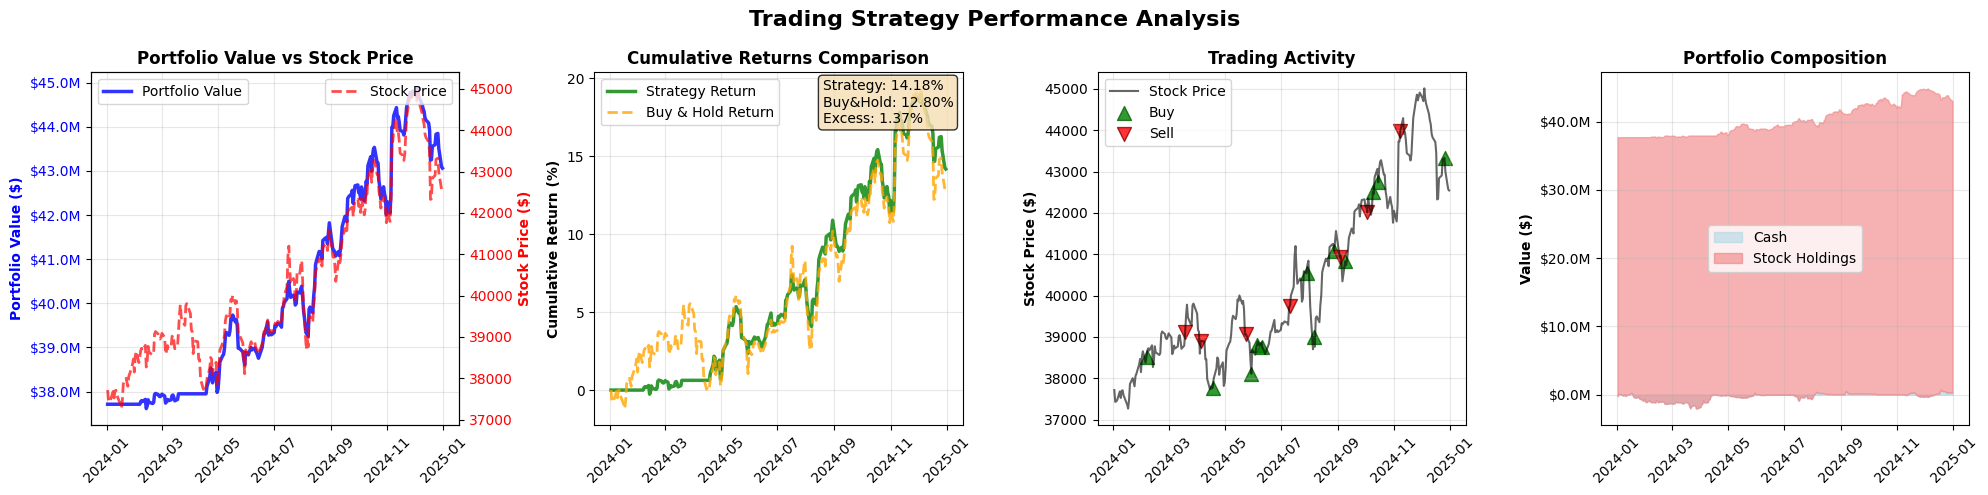


DETAILED PERFORMANCE METRICS
               Metric       Value
      Initial Capital     $37.72M
Final Portfolio Value     $43.06M
         Total Return       0.14%
     Total Return (%)      14.18%
Buy & Hold Return (%)      12.80%
    Excess Return (%)       1.37%
     Number of Trades          17
           Final Cash $304,563.48
         Final Shares        1005
    Final Stock Price  $42,544.22
Annualized Return (%)      14.18%
       Volatility (%)       7.91%
         Sharpe Ratio      1.7218
     Max Drawdown (%)      -4.03%

=== ADDITIONAL INSIGHTS ===
Trading period: 2024-01-02 to 2024-12-31
Total trading days: 252
Risk-adjusted performance (Sharpe Ratio): 1.7218
Maximum drawdown: -4.03%
Annual volatility: 7.91%


In [13]:
# Step 1: Calculate returns with the accurate function
print("Calculating returns...")
df_results, trade_log, metrics = calculate_returns(df_market_synced, df_operation_synced)

# Step 2: Display basic results
print("=== PERFORMANCE SUMMARY ===")
print(f"Total Return: {metrics['Total Return (%)']:.2f}%")
print(f"Buy & Hold Return: {metrics['Buy & Hold Return (%)']:.2f}%")
print(f"Number of Trades: {metrics['Number of Trades']}")
print(f"Final Portfolio Value: ${metrics['Final Portfolio Value']/1e6:.2f}M")

# Step 3: Show trade log if trades were executed
if len(trade_log) > 0:
    print(f"\n=== TRADE LOG ===")
    print(f"First 10 trades:")
    print(trade_log.head(10))
    
    print(f"\nTrade summary:")
    print(trade_log['action'].value_counts())
else:
    print("\n⚠️ No trades were executed!")

# Step 4: Create the performance visualization
print("\nGenerating performance analysis plots...")
fig = plot_performance_analysis(df_results, metrics)

# Step 5: Additional analysis (optional)
print(f"\n=== ADDITIONAL INSIGHTS ===")
print(f"Trading period: {df_results.index[0].strftime('%Y-%m-%d')} to {df_results.index[-1].strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(df_results)}")

if 'Sharpe Ratio' in metrics:
    print(f"Risk-adjusted performance (Sharpe Ratio): {metrics['Sharpe Ratio']:.4f}")
if 'Max Drawdown (%)' in metrics:
    print(f"Maximum drawdown: {metrics['Max Drawdown (%)']:.2f}%")
if 'Volatility (%)' in metrics:
    print(f"Annual volatility: {metrics['Volatility (%)']:.2f}%")

Processing all methods...

Processing SLEIPNIR...
Operation date range: 2024-01-01 00:00:00 to 2025-01-01 00:00:00
Market data entries in date range: 252
Operation data entries: 46
After synchronization:
Number of dates: 252
Date range: 2024-01-02 00:00:00 to 2024-12-31 00:00:00
  Total Return: 14.18%
  Number of Trades: 17
  Final Value: $0.04B

Processing Rule-Based...
Operation date range: 2024-01-08 00:00:00 to 2024-12-31 00:00:00
Market data entries in date range: 248
Operation data entries: 248
After synchronization:
Number of dates: 248
Date range: 2024-01-08 00:00:00 to 2024-12-31 00:00:00
  Total Return: 4.12%
  Number of Trades: 10
  Final Value: $0.04B

Processing RAG-LLM...
Operation date range: 2024-01-01 00:00:00 to 2025-01-01 00:00:00
Market data entries in date range: 252
Operation data entries: 45
After synchronization:
Number of dates: 252
Date range: 2024-01-02 00:00:00 to 2024-12-31 00:00:00
  Total Return: 9.72%
  Number of Trades: 8
  Final Value: $0.04B

Processi

/tmp/ipykernel_6293/3168799736.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_capital = initial_capital * df_combined['close'][0]
/tmp/ipykernel_6293/3168799736.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_capital = initial_capital * df_combined['close'][0]
/tmp/ipykernel_6293/3168799736.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_capital = initial_capital * df_combined['close'][0]
/tmp

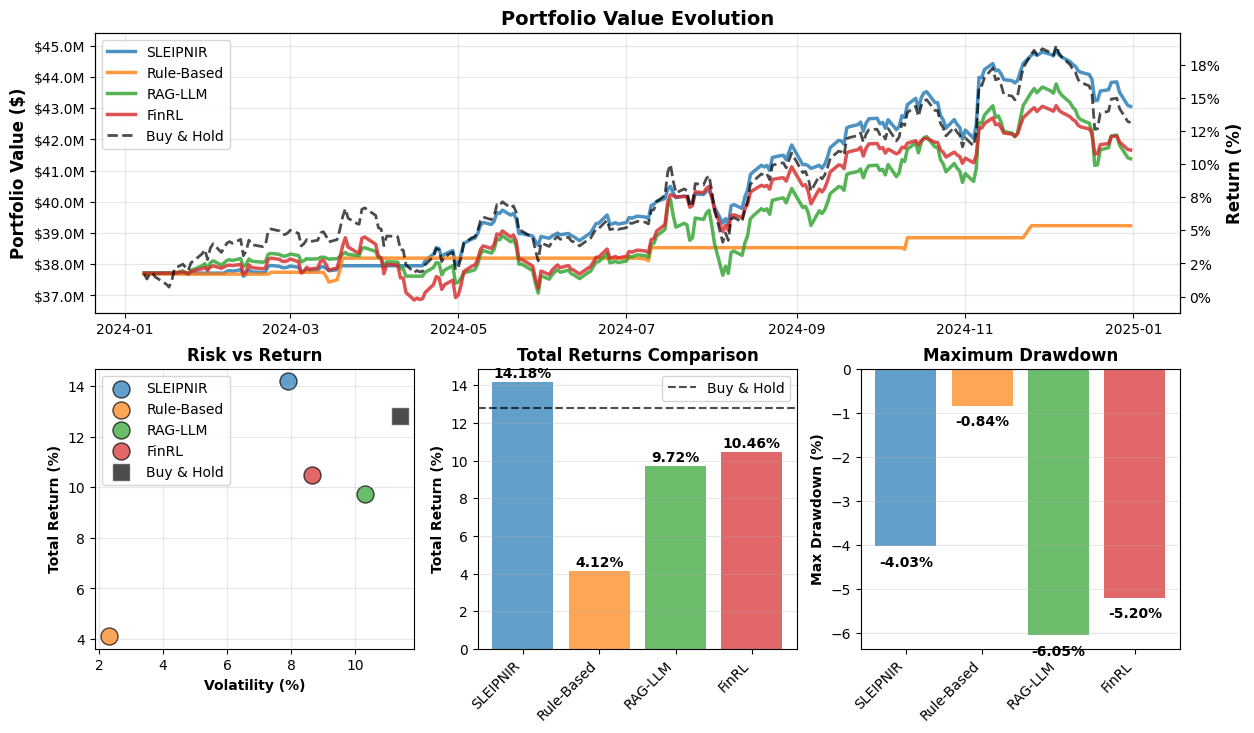

In [14]:
all_results, all_trade_logs, all_metrics = calculate_returns_for_all_methods(df_market, df_operations, methods)

# Debug: Check what methods we actually have
print("Debug: Checking available methods...")
print("Methods list:", methods)
print("Available in all_results:", list(all_results.keys()) if 'all_results' in globals() else "all_results not defined")
print("Available in all_metrics:", list(all_metrics.keys()) if 'all_metrics' in globals() else "all_metrics not defined")

# # Create the comparison plot with error handling
# try:
#     fig_comparison = plot_methods_comparison(all_results, all_metrics, methods)
#     if fig_comparison is None:
#         print("Failed to create comparison plot - no valid methods found")
#     fig_comparison.savefig(f'graphics/FINAI_compare_{ticker}.pdf')
# except Exception as e:
#     print(f"Error creating comparison plot: {e}")
#     print("Let's debug the data structure...")
    
#     # Debug information
#     if 'all_results' in globals():
#         print(f"all_results keys: {list(all_results.keys())}")
#         for key in all_results.keys():
#             print(f"  {key}: {type(all_results[key])}, shape: {all_results[key].shape if hasattr(all_results[key], 'shape') else 'no shape'}")
    
#     if 'all_metrics' in globals():
#         print(f"all_metrics keys: {list(all_metrics.keys())}")
#         for key in all_metrics.keys():
#             print(f"  {key}: {type(all_metrics[key])}")

fig_comparison = plot_methods_comparison(all_results, all_metrics, methods)
if fig_comparison is None:
    print("Failed to create comparison plot - no valid methods found")
fig_comparison.subplots_adjust(left=0.07, right=0.95, top=0.95, bottom=0.1)
fig_comparison.savefig(f'graphics/FINAI_compare_{ticker}.pdf')
# fig_comparison.savefig(f'graphics/FINAI_compare_{ticker}.svg')
            